# Experiment 02 - Comparison of Activation Functions for Simple CNN

## Activation Function Impact on CNN Edge Inference
### Martin Power
### 9939245

This experiment has two goals. First of all, to be observe the impact on sparsity of using either ReLU, Swish or Mish activation functions. Secondly, since Swish and Mish are displacing ReLU due to their potential higher model accuracy, this experiment will compare the accuracy of ReLU, Swish and Mish when trained on the same dataset and using the same network architecture.

A simple CNN is used on the Fashion-MNIST dataset. This model is configured to use either ReLU, Swish or Mish and then trained on the data. The sparsity profile code from the previous experiment is reused to allow the impact of the chosen activation on the sparsity profile to be observed. The model accuracy for the three activation functions will also be compared. This will allow the sparsity profile versus the model accuracy to be assessed.

The network and its training routine is described in a Python script (.py) (Griffo, 2017) and has been extracted into a Jupyter notebook (.ipynb). At the time of the experiment, Swish and Mish were not directly supported by the frameworks and so they were added as custom functions in this notebook

A summary of changes and additions to the notebook relative to the original Python script is provided below:
*	Converted from Python Script (.py) to Interactive Notebook (.ipynb)
*	Added code for time stamping experiments
*	Fixed issue with image dimension ordering and newer Keras versions
*	Added custom activation function for Swish
*	Added custom activation function for Mish
*	Print loss as well as accuracy
* 	Store loss and accuracy to CSV for further analysis

The original Python script is available at:
https://github.com/umbertogriffo/Fashion-mnist-cnn-keras

In [1]:
import numpy as np  # linear algebra

import os
import matplotlib.pyplot as plt
import math as mt

# model evaluation
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K
from keras.datasets import fashion_mnist

### Get time and date stamp for experiment

In [2]:
from datetime import date
from datetime import datetime

In [3]:
now = datetime.now()

dt_string = now.strftime("%Y%m%d_%H%M%S")	

### Select activation function
* ReLU
* Swish
* Mish

Select by uncommenting the desired activation function

In [4]:
#act = "relu"
act = "swish"
#act = "mish"

Set up strings for filenames to store CSV and PNG files

In [5]:
csv_string = "fashion_mnist_"+act+"_"+dt_string+".csv"
png_acc_string = "fashion_mnist_"+act+"_"+dt_string+"_acc.png"
png_loss_string = "fashion_mnist_"+act+"_"+dt_string+"_loss.png"

Fix dimension ordering
* see https://stackoverflow.com/questions/40697938/regarding-set-image-dim-orderingtf-in-keras

In [6]:
# MPP K.set_image_dim_ordering('th')
# https://stackoverflow.com/questions/40697938/regarding-set-image-dim-orderingtf-in-keras
K.set_image_data_format('channels_first')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(K.image_data_format())

channels_first


### Define Activation Functions for Swish and Mish

In [7]:
from keras.backend import softplus
from keras.backend import tanh
def mish(x):
    return (x * tanh(softplus(x)))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'mish': Activation(mish)})

In [8]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
get_custom_objects().update({'swish': Activation(swish)})

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define path to save model
model_path_cnn = './fm_cnn_model_mpower1_v04_relu.h5'

### Network Training

In [10]:
# training configuration
batch_size = 400 #MPP <-- Revisit this batch size and see if it is appropriate
epochs = 150
#epochs = 3 # MPP Reduced from 150 to 5 for intitial debug
# prepare callbacks
callbacks = [
    EarlyStopping(
        #monitor='val_acc',
        monitor='val_accuracy',
        patience=10,
        mode='max',
        verbose=1),
    ModelCheckpoint(
        model_path_cnn,
        #monitor='val_acc',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True, #MPP
        mode='max',
        verbose=0)
]

# k-fold configuration
n_splits = 5

In [11]:
def average(numbers):
    """
    Return the sample arithmetic mean of data.
    :param numbers: a list of float
    :return:
    """
    try:
        return float(sum(numbers)) / max(len(numbers), 1)
    except ZeroDivisionError:
        return 0


def sum_of_square_deviation(numbers, mean):
    """
    Return sum of square deviations of sequence data.
    :param numbers: a list of float
    :param mean:
    :return:
    """
    try:
        return float(1 / len(numbers) * sum((x - mean) ** 2 for x in numbers))
    except ZeroDivisionError:
        return 0

### CNN Model Definition
* 3 Convolution Layers
* 3 Pooling Layers
* 3 Dense Layers
* 10 Outputs

In [12]:
def model_cnn(num_classes, act='relu'):
    """Convolutional Neural Network

    The network topology can be summarized as follows:

        Convolutional layer with 32 feature maps of size 5×5.
        Pooling layer taking the max over 2*2 patches.
        Convolutional layer with 64 feature maps of size 5×5.
        Pooling layer taking the max over 2*2 patches.
        Convolutional layer with 128 feature maps of size 1×1.
        Pooling layer taking the max over 2*2 patches.
        Flatten layer.
        Fully connected layer with 1024 neurons and rectifier activation.
        Dropout layer with a probability of 50%.
        Fully connected layer with 510 neurons and rectifier activation.
        Dropout layer with a probability of 50%.
        Output layer.

    """

    print("Build CNN Model with ",act,"as Activation Function")
    # create model
    model = Sequential()
    
    #get_custom_objects().update({'swish': Activation(swish )})
    
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), padding='same', activation=act))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(64, (5, 5), padding='same', activation=act))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(128, (1, 1), padding='same', activation=act))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(1024, activation=act, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation=act, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    lrate = 0.01
    decay = lrate / epochs
    #/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
    # "The `lr` argument is deprecated, use `learning_rate` instead.")
    #sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=True)
    sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

### Fashion-MNIST Dataset
* Load and prepare data

In [13]:
#########################################################
# DATA PREPARATION
# The train set has 60k rows and 784 columns, so its shape is (60k,784).
# Each row is a 28 by 28 pixel picture.
# I will reshape the train set to have (60k,1) shape, i.e. each row will contain a 28 by 28 matrix of pixel color values.
# Same for the test set.
#########################################################
# get data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print('train shape: {}'.format(x_train.shape))
print('test shape: {}'.format(x_test.shape))

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

train shape: (60000, 28, 28)
test shape: (10000, 28, 28)
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


In [14]:
y_train_CNN = y_train  # only labels i.e targets digits
X_train_CNN = x_train.reshape(x_train.shape[0], 1, 28, 28).astype(np.uint8)
print('train shape after reshape: {}'.format(X_train_CNN.shape))

y_test_CNN = y_test  # only labels i.e targets digits
X_test_CNN = x_test.reshape(x_test.shape[0], 1, 28, 28).astype(np.uint8)
print('test shape after reshape: {}'.format(X_test_CNN.shape))

train shape after reshape: (60000, 1, 28, 28)
test shape after reshape: (10000, 1, 28, 28)


In [15]:
# normalize inputs from 0-255 to 0-1
X_train_CNN = X_train_CNN / 255
X_test_CNN = X_test_CNN / 255

In [16]:
# one hot encode outputs
y_train_CNN = to_categorical(y_train_CNN)
y_test_CNN = to_categorical(y_test_CNN)
num_classes = y_train_CNN.shape[1]

In [17]:
X_train = X_train_CNN
X_val = X_test_CNN
y_train = y_train_CNN
y_val = y_test_CNN

### Initial Model Evaluation

In [18]:
#########################################################
# BUILDE THE MODEL AND EVALUATE IT USING K-FOLD
#########################################################

kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
kf.get_n_splits(X_train)

acc_scores = list()

for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    print('\n Fold %d' % (fold))

    X_tr, X_v = X_train[train_index], X_train[test_index]
    y_tr, y_v = y_train[train_index], y_train[test_index]
    # build the model
    model = model_cnn(num_classes, act)
    # fit model
    model.fit(
        X_tr,
        y_tr,
        epochs=epochs,
        validation_data=(X_v, y_v),
        verbose=2,
        batch_size=batch_size,
        callbacks=callbacks,
        shuffle=True
    )

    acc = model.evaluate(X_v, y_v, verbose=0)
    acc_scores.append(acc[1])

    print('Fold %d: Accuracy %.2f%%' % (fold, acc[1] * 100))

print('Accuracy scores: ', acc_scores)


 Fold 0
Build CNN Model with  swish as Activation Function
Epoch 1/150
120/120 - 16s - loss: 2.2948 - accuracy: 0.1451 - val_loss: 2.2672 - val_accuracy: 0.3028
Epoch 2/150
120/120 - 2s - loss: 1.3654 - accuracy: 0.5071 - val_loss: 0.7238 - val_accuracy: 0.7464
Epoch 3/150
120/120 - 2s - loss: 0.7511 - accuracy: 0.7233 - val_loss: 0.6327 - val_accuracy: 0.7673
Epoch 4/150
120/120 - 2s - loss: 0.6613 - accuracy: 0.7533 - val_loss: 0.5632 - val_accuracy: 0.7905
Epoch 5/150
120/120 - 2s - loss: 0.5901 - accuracy: 0.7814 - val_loss: 0.4989 - val_accuracy: 0.8152
Epoch 6/150
120/120 - 2s - loss: 0.5418 - accuracy: 0.7999 - val_loss: 0.4656 - val_accuracy: 0.8279
Epoch 7/150
120/120 - 2s - loss: 0.5032 - accuracy: 0.8110 - val_loss: 0.4311 - val_accuracy: 0.8412
Epoch 8/150
120/120 - 2s - loss: 0.4733 - accuracy: 0.8240 - val_loss: 0.4187 - val_accuracy: 0.8423
Epoch 9/150
120/120 - 2s - loss: 0.4528 - accuracy: 0.8324 - val_loss: 0.3981 - val_accuracy: 0.8548
Epoch 10/150
120/120 - 2s - lo

In [19]:
mean_acc = average(acc_scores)
standard_deviation_acc = mt.sqrt(sum_of_square_deviation(acc_scores, mean_acc))

print('=====================')
print('Mean Accuracy %f' % mean_acc)
print('=====================')
print('=====================')
print('Stdev Accuracy %f' % standard_deviation_acc)
print('=====================')

Mean Accuracy 0.915883
Stdev Accuracy 0.004365


### Final Model Training
* Train using entire training set
* Validate using entire validation set
* Print Model Summary

In [20]:
model = model_cnn(num_classes,act)
# Fit the final model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,
                    callbacks=callbacks, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_val, y_val, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))
print("Accuracy: %.2f%%" % (scores[1] * 100))

Build CNN Model with  swish as Activation Function
Epoch 1/150
150/150 - 3s - loss: 1.9491 - accuracy: 0.2825 - val_loss: 0.8446 - val_accuracy: 0.6989
Epoch 2/150
150/150 - 2s - loss: 0.7877 - accuracy: 0.7100 - val_loss: 0.6658 - val_accuracy: 0.7541
Epoch 3/150
150/150 - 2s - loss: 0.6756 - accuracy: 0.7495 - val_loss: 0.6008 - val_accuracy: 0.7736
Epoch 4/150
150/150 - 2s - loss: 0.6073 - accuracy: 0.7749 - val_loss: 0.5454 - val_accuracy: 0.7969
Epoch 5/150
150/150 - 2s - loss: 0.5472 - accuracy: 0.7955 - val_loss: 0.4987 - val_accuracy: 0.8136
Epoch 6/150
150/150 - 2s - loss: 0.5059 - accuracy: 0.8113 - val_loss: 0.4663 - val_accuracy: 0.8299
Epoch 7/150
150/150 - 2s - loss: 0.4755 - accuracy: 0.8219 - val_loss: 0.4508 - val_accuracy: 0.8302
Epoch 8/150
150/150 - 2s - loss: 0.4501 - accuracy: 0.8342 - val_loss: 0.4212 - val_accuracy: 0.8416
Epoch 9/150
150/150 - 2s - loss: 0.4271 - accuracy: 0.8412 - val_loss: 0.4044 - val_accuracy: 0.8520
Epoch 10/150
150/150 - 2s - loss: 0.4111

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 28, 28)        832       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 14, 14)        51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 7, 7)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 7, 7)         8320      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 128, 4, 4)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)             

### Identify Convolution Layers within Model

This code parses the model and finds all the layers that have a ReLU (or SoftMax) activation function.

An array called "relu_layers" is used to store this information. Every layer with a non-linear activation is set to 1 in this array. This array is then used in later code to determine which layers are analysed for sparsity profile or not

In [22]:
n=0
relu=0
#relu_layers = np.zeros((len(layer_outs)))
relu_layers = np.zeros((len(model.layers)))
layer_names = []
#layer_acts = []
for layer in model.layers:
    #print(layer.__class__.__name__)
    try:
        #if(layer.activation.__name__!="linear"):
        if((layer.__class__.__name__=='Conv2D')or(layer.__class__.__name__=='Dense')):
            #print(n,"\t",layer.name,"\t", layer.__class__.__name__,"\t", layer.activation.__name__)
            print(n,"\t",layer.name,"\t", layer.__class__.__name__)
            relu+=1
            relu_layers[n]=1
            
    except AttributeError:
        print(n,"\t",layer.name,"\t", layer.__class__.__name__)
        
    layer_names.append(layer.name)
    # if(relu_layers[n]==1):
    #     layer_acts.append(layer.activation.__name__)
    # else:
    #     layer_acts.append("None")
    n+=1
        
print("Number of layers with Activation:",relu)
print("Number of layers:",n)

0 	 conv2d_15 	 Conv2D
2 	 conv2d_16 	 Conv2D
4 	 conv2d_17 	 Conv2D
7 	 dense_15 	 Dense
9 	 dense_16 	 Dense
11 	 dense_17 	 Dense
Number of layers with Activation: 6
Number of layers: 12


### Plot Accuracy and Loss

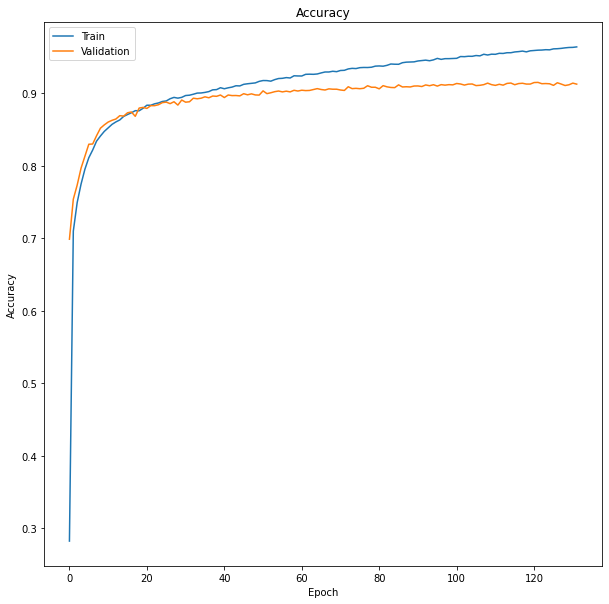

In [23]:
# summarize history for accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(png_acc_string)
plt.show()

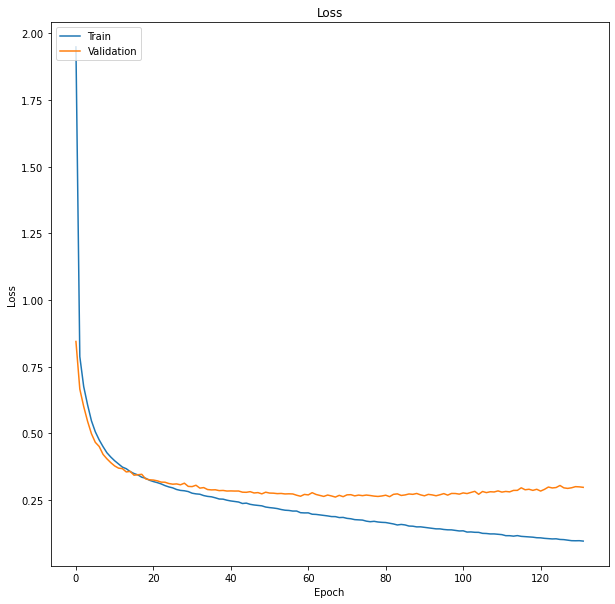

In [24]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(png_loss_string)
plt.show()

### Create Dataframe to store Loss and Accuracy Information Per Epoch
* Store Training Loss, Validation Loss, Training Accuracy and Validation Accuracy in Dataframe
* Information captured per Epoch
* Write out as CSV

In [26]:
column_names = ["Training Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"]

In [27]:
import pandas as pd

In [28]:
df1 = pd.DataFrame(columns=column_names)

In [29]:
df1['Training Loss']       = history.history['loss']
df1['Validation Loss']     = history.history['val_loss']
df1['Training Accuracy']   = history.history['accuracy']
df1['Validation Accuracy'] = history.history['val_accuracy']

In [30]:
df1.to_csv(csv_string)

### Get Output Activations from Each Layer of Model

The code in the next two cells is based on code provided at https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer/45430345 "Keras, How to get the output of each layer?" and has been updated to work with the latest versions of Keras and Tensorflow

In [31]:
#Getting output of each layer
from tensorflow.keras import backend as K

input_shape = (28, 28, 1)
inp = model.input                                           # input 
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

In [32]:
def get_layer_outs(img):
    layer_outs=[]
    #test = preprocess_img(img)
    test = np.expand_dims(img, axis=0)
    count = 0
    for func in functors:
        layer_outs.append(np.asarray(func([test])))
        count+=1
    
    return layer_outs

### Pick an image from the validation set and extract the activation sparsity profile

In [34]:
layer_outs = get_layer_outs(X_val[0])

In [36]:
debug=True
layer_sparsity = np.zeros(np.count_nonzero(relu_layers))
layer_sparsity_idx = 0
layer_outs = get_layer_outs(X_val[2])
#if(debug):
#    print(layer_outs)
#dff = pd.DataFrame(columns=column_names)
for i in range(len(layer_outs)):
    if(relu_layers[i]==1):
        non_zero = np.count_nonzero(layer_outs[i])
        total    = layer_outs[i].size
        zero     = total-non_zero
        sparsity = (100.0*zero)/total
        density  = (100.0*non_zero)/total
        min_val  = layer_outs[i].min()
        max_val  = layer_outs[i].max()
        mean_val = layer_outs[i].mean()
        std_val  = layer_outs[i].std()
        if(debug):
            print("Layer", i, layer_names[i],"\tNon_Zero",non_zero,"\tTotal",total,"\t%Sparsity",sparsity,"\t%Density",density)
        layer_sparsity[layer_sparsity_idx]= sparsity
        layer_sparsity_idx+=1

Layer 0 conv2d_15 	Non_Zero 25088 	Total 25088 	%Sparsity 0.0 	%Density 100.0
Layer 2 conv2d_16 	Non_Zero 12544 	Total 12544 	%Sparsity 0.0 	%Density 100.0
Layer 4 conv2d_17 	Non_Zero 6272 	Total 6272 	%Sparsity 0.0 	%Density 100.0
Layer 7 dense_15 	Non_Zero 1024 	Total 1024 	%Sparsity 0.0 	%Density 100.0
Layer 9 dense_16 	Non_Zero 512 	Total 512 	%Sparsity 0.0 	%Density 100.0
Layer 11 dense_17 	Non_Zero 10 	Total 10 	%Sparsity 0.0 	%Density 100.0


### Download CSV and PNG files from Colab

In [44]:
from google.colab import files

files.download(csv_string)
files.download(png_acc_string)
files.download(png_loss_string)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>